In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
from typing import Union, List
import datetime
from pycmqlib3.utility import misc

from pycmqlib3.utility.dbaccess import *
from pycmqlib3.utility import dataseries
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
#pd.set_option('display.width', 1000)

In [9]:
update_contract_list_table(datetime.date(2023,1,10))

# load eod mark from exchange

In [6]:
from misc_scripts.aks_data_update import update_hist_fut_daily

update_hist_fut_daily(start_date=datetime.date(2022,12,22),
                          end_date=datetime.date(2023,1,6),
                          exchanges=['GFEX'],
                          flavor='mysql',
                          fut_table='fut_daily')

exch = GFEX, date=2023-01-06
exch = GFEX, date=2023-01-05
exch = GFEX, date=2023-01-04
exch = GFEX, date=2023-01-03
exch = GFEX, date=2022-12-30
exch = GFEX, date=2022-12-29
exch = GFEX, date=2022-12-28
exch = GFEX, date=2022-12-27
exch = GFEX, date=2022-12-26
exch = GFEX, date=2022-12-23
exch = GFEX, date=2022-12-22


[]

# check factor data

In [18]:
prod_list = ['rb', 'hc', 'i', 'j', 'jm']
roll_label = 'CAL_30b'
freq = 's1'
db_table = 'fut_fact_data'
fact_list = ["ryield_1_nmb_120", "basmom_100_nma_120", "basmom_170_nma_120",
            "ryield_1_nma_20", "ryield_1_nma_110"]
start_date = datetime.date(2022,10,1)
end_date = datetime.date(2022,12,30)
df = load_factor_data(prod_list, 
                      factor_list = fact_list,
                      roll_label = roll_label,
                      start = start_date,
                      end = end_date,
                      freq = freq,
                      db_table = db_table)
print(df)

     product_code        date  serial_no serial_key           fact_name  \
0              hc  2022-10-10          0          0  basmom_100_nma_120   
1              hc  2022-10-10          0          0  basmom_170_nma_120   
2              hc  2022-10-10          0          0    ryield_1_nma_110   
3              hc  2022-10-10          0          0     ryield_1_nma_20   
4              hc  2022-10-10          0          0    ryield_1_nmb_120   
...           ...         ...        ...        ...                 ...   
1495           rb  2022-12-30          0          0  basmom_100_nma_120   
1496           rb  2022-12-30          0          0  basmom_170_nma_120   
1497           rb  2022-12-30          0          0    ryield_1_nma_110   
1498           rb  2022-12-30          0          0     ryield_1_nma_20   
1499           rb  2022-12-30          0          0    ryield_1_nmb_120   

       fact_val  
0      1.010839  
1      0.077167  
2      3.024740  
3     14.313413  
4      0.

# check upcoming nearby rolling 

In [19]:
end_date = datetime.date(2023, 1, 3) # datetime.date.today()
start_date = misc.day_shift(end_date, '-120d')
print(start_date, end_date)

roll_dict = {
    'm': 30,
    'RM': 30,
    'rb': 30,
    'ru': 30,
    'sc': 20,
    'lu': 45,
    'eb': 20,
    'eg': 30,
    'cu': 25,
    'jd': 40,
    'lh': 40,
    'T': 20,
    'pg': 30,
}

shift_scope = 15
for prod in ['m', 'RM', 'rb', 'sc', 'lu', 'eb', 'eg', 'cu', 'jd', 'lh', 'T','pg']:
    test_roll = roll_dict[prod] + shift_scope
    nc_df1 = misc.nearby(prod, 1, start_date = start_date, end_date = end_date, roll_rule = f'-{test_roll}b',shift_mode=1)    
    curr_cont = nc_df1['contract'][-shift_scope-1]
    for i in range(shift_scope, 0, -1):
        if curr_cont != nc_df1['contract'][-i]:
            print('%s roll into %s in %s bzdays for current roll rule (%s)' % 
                  (curr_cont, nc_df1['contract'][-i], shift_scope - i, f'-{roll_dict[prod]}b'))
            #print(nc_df1.tail(10))
            break


2022-09-05 2023-01-03
lu2304 roll into lu2305 in 13 bzdays for current roll rule (-45b)
eb2302 roll into eb2303 in 12 bzdays for current roll rule (-20b)
eg2302 roll into eg2303 in 2 bzdays for current roll rule (-30b)
cu2302 roll into cu2303 in 1 bzdays for current roll rule (-25b)
pg2302 roll into pg2303 in 2 bzdays for current roll rule (-30b)


In [52]:
#df = pd.read_csv('C:\\dev\\pyktrader3\\process\\option_test\\volgrids_IO_220715.csv', header=None)
#df

In [4]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

# check contract by product (for OI/volume evolution)

In [22]:
print(load_fut_by_product('zn', 'SHFE', datetime.date(2022,12,30),datetime.date(2023,1,3)))

    instID        date     open     high      low    close  volume  \
0   zn2301  2022-12-30  23780.0  23950.0  23705.0  23950.0    8781   
1   zn2301  2023-01-03  23845.0  23950.0  23370.0  23605.0    6030   
2   zn2302  2022-12-30  23745.0  23805.0  23590.0  23765.0   94014   
3   zn2302  2023-01-03  23760.0  23805.0  23230.0  23455.0   98610   
4   zn2303  2022-12-30  23715.0  23780.0  23560.0  23730.0   26100   
5   zn2303  2023-01-03  23730.0  23780.0  23205.0  23420.0   32426   
6   zn2304  2022-12-30  23680.0  23740.0  23535.0  23695.0    3276   
7   zn2304  2023-01-03  23700.0  23740.0  23180.0  23400.0    3058   
8   zn2305  2022-12-30  23660.0  23700.0  23510.0  23665.0     301   
9   zn2305  2023-01-03  23660.0  23700.0  23140.0  23330.0     479   
10  zn2306  2022-12-30  23605.0  23625.0  23515.0  23625.0      22   
11  zn2306  2023-01-03  23675.0  23675.0  23085.0  23300.0     116   
12  zn2307  2022-12-30  23550.0  23550.0  23420.0  23420.0      22   
13  zn2307  2023-01-

# AKShare load future daily data

In [24]:
from misc_scripts.aks_data_update import update_hist_fut_daily, update_spot_daily, \
                            update_exch_receipt_table, update_exch_inv_table, update_rank_table

In [39]:
update_hist_fut_daily(datetime.date(2022,12,3), datetime.date(2023,1,3), exchanges = ['GFEX'], flavor = 'mysql', fut_table = 'fut_daily')

exch = GFEX, date=2023-01-03
exch = GFEX, date=2022-12-30
exch = GFEX, date=2022-12-29
exch = GFEX, date=2022-12-28
exch = GFEX, date=2022-12-27
exch = GFEX, date=2022-12-26
exch = GFEX, date=2022-12-23
exch = GFEX, date=2022-12-22
exch = GFEX, date=2022-12-21
no data for exch = GFEX, date = 2022-12-21
exch = GFEX, date=2022-12-20
no data for exch = GFEX, date = 2022-12-20
exch = GFEX, date=2022-12-19
no data for exch = GFEX, date = 2022-12-19
exch = GFEX, date=2022-12-16
no data for exch = GFEX, date = 2022-12-16
exch = GFEX, date=2022-12-15
no data for exch = GFEX, date = 2022-12-15
exch = GFEX, date=2022-12-14
no data for exch = GFEX, date = 2022-12-14
exch = GFEX, date=2022-12-13
no data for exch = GFEX, date = 2022-12-13
exch = GFEX, date=2022-12-12
no data for exch = GFEX, date = 2022-12-12
exch = GFEX, date=2022-12-09
no data for exch = GFEX, date = 2022-12-09
exch = GFEX, date=2022-12-08
no data for exch = GFEX, date = 2022-12-08
exch = GFEX, date=2022-12-07
no data for exch = 

[('GFEX', datetime.date(2022, 12, 21)),
 ('GFEX', datetime.date(2022, 12, 20)),
 ('GFEX', datetime.date(2022, 12, 19)),
 ('GFEX', datetime.date(2022, 12, 16)),
 ('GFEX', datetime.date(2022, 12, 15)),
 ('GFEX', datetime.date(2022, 12, 14)),
 ('GFEX', datetime.date(2022, 12, 13)),
 ('GFEX', datetime.date(2022, 12, 12)),
 ('GFEX', datetime.date(2022, 12, 9)),
 ('GFEX', datetime.date(2022, 12, 8)),
 ('GFEX', datetime.date(2022, 12, 7)),
 ('GFEX', datetime.date(2022, 12, 6)),
 ('GFEX', datetime.date(2022, 12, 5))]

In [30]:
import akshare as ak

In [32]:
ak.get_futures_daily(start_date = "20230103", end_date = "20230103", market = "SHFE")

# ak.get_futures_daily(start_date='20230103',end_date='20230106', market='DCE')

第1次链接失败, 最多尝试 20 次
第2次链接失败, 最多尝试 20 次


,symbol,date,open,high,low,close,volume,open_interest,turnover,settle,pre_settle,variety
0,CU2301,20230103,66340,66340,65430,65900,18361,39520,1205950480,65680,66180,CU
1,CU2302,20230103,66160,66250,65310,65790,49935,96846,3279231450,65670,66120,CU
2,CU2303,20230103,66200,66250,65270,65780,36213,135338,2375934930,65610,66110,CU
3,CU2304,20230103,66240,66240,65220,65700,9532,48020,624441320,65510,66050,CU
4,CU2305,20230103,66090,66090,65140,65650,4435,28979,290403800,65480,66000,CU
...,...,...,...,...,...,...,...,...,...,...,...,...
243,SP2310,20230103,6342,6358,6322,6322,11,75,69740,6340,6436,SP
244,SP2311,20230103,6320,6344,6304,6312,29,310,183396,6324,6404,SP
245,SP2312,20230103,6292,6328,6290,6290,14,53,88256,6304,6358,SP
246,SC_TAS2302,20230103,,,,,0,,,,,SC_TAS


# check nearby rolling

In [35]:
start_date = datetime.date(2020,1,2)
end_date = datetime.date(2022,10,14)
nc_df1 = misc.nearby('pg', 1, start_date = start_date, end_date = end_date, roll_rule='-32b',shift_mode=1)
#nc_df2 = misc.nearby('pg', 1, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=1)

nc_df1 #, nc_df2
#nc1_df = misc.nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=1)
#nc2_df = misc.nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=2)
#print(nc_df, nc1_df, nc2_df)

continuous contract stopped at pg2002 for start = 2020-01-02, expiry= 2020-01-02
continuous contract stopped at pg2003 for start = 2020-01-02, expiry= 2020-02-11
continuous contract stopped at pg2004 for start = 2020-01-02, expiry= 2020-03-11
continuous contract stopped at pg2005 for start = 2020-01-02, expiry= 2020-04-07
continuous contract stopped at pg2006 for start = 2020-01-02, expiry= 2020-05-08
continuous contract stopped at pg2007 for start = 2020-01-02, expiry= 2020-06-10
continuous contract stopped at pg2008 for start = 2020-01-02, expiry= 2020-07-13
continuous contract stopped at pg2009 for start = 2020-01-02, expiry= 2020-08-12
continuous contract stopped at pg2010 for start = 2020-01-02, expiry= 2020-09-03


,open,high,low,close,volume,openInterest,contract,shift
date,,,,,,,,
2020-03-30,1650.0,1738.0,1618.0,1666.0,85116,10171,pg2011,-700.0
2020-03-31,1730.0,1845.0,1704.0,1845.0,89839,18891,pg2011,-700.0
2020-04-01,1847.0,1942.0,1830.0,1924.0,199435,21955,pg2011,-700.0
2020-04-02,1944.0,2079.0,1907.0,2079.0,206057,26486,pg2011,-700.0
2020-04-03,2090.0,2175.0,2032.0,2175.0,323535,35752,pg2011,-700.0
...,...,...,...,...,...,...,...,...
2022-10-10,4994.0,5022.0,4895.0,4977.0,88945,71603,pg2211,-106.0
2022-10-11,4954.0,5036.0,4919.0,5019.0,102541,66559,pg2211,-106.0
2022-10-12,5002.0,5021.0,4946.0,5003.0,80031,63549,pg2211,-106.0


In [49]:
start_date = datetime.date(2021,1,1)
end_date = datetime.date(2022,6,28)

#load_fut_by_product('i', 'DCE', start_date ,end_date, freq = 'd')

prodcode = 'sc'
df1 = dataseries.nearby(prodcode, n = 1, start_date = start_date, end_date = end_date,
           roll_rule = '-25b', freq = 'd', shift_mode = 1, 
           adj_field = 'close', calc_fields = ['open', 'close', 'high', 'low'], 
           fill_cont = False,
          )

df2 = misc.nearby(prodcode, n = 1, start_date = start_date, end_date = end_date, roll_rule = '-25b', freq = 'd', shift_mode = 1)

print(df1, df2)

           contract   open   high    low  close  volume  openInterest  \
date                                                                    
2021-01-04   sc2103  272.1  289.5  271.1  287.8   33904         28066   
2021-01-05   sc2103  282.1  287.7  275.9  279.0   51266         30308   
2021-01-06   sc2103  282.6  294.8  278.8  291.3   63707         34609   
2021-01-07   sc2103  287.6  306.0  287.6  303.6   67590         39517   
2021-01-08   sc2103  303.0  308.6  296.7  306.7   65501         43933   
...             ...    ...    ...    ...    ...     ...           ...   
2022-06-22   sc2208  709.0  718.2  679.9  680.9  234871         39152   
2022-06-23   sc2208  673.0  700.3  669.5  691.4  284977         40444   
2022-06-24   sc2208  695.6  703.2  667.2  672.1  292048         41656   
2022-06-27   sc2209  685.5  698.8  672.7  694.4   44928         20905   
2022-06-28   sc2209  695.6  721.9  686.7  720.8   43973         22481   

                expiry  month  price_chg   roll_da

# this is testing for new nearby rolling

In [73]:
from pycmqlib3.utility.dataseries import *

ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF", 'nr']
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR', 'SA', 'lh', 'PK',] # 'CY',] 
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC', 'IM',]
bond_fut_mkts = ['T', 'TF', 'TS']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

In [74]:
setting_dict = {
    'rb': [datetime.date(2009,8,13), datetime.date(2009,8,13), 5000, '-20b'], 
    'hc': [datetime.date(2014,3,21), datetime.date(2015,12,11), 5000, '-20b'],
    'i': [datetime.date(2013,10,18), datetime.date(2014,4,10), 5000, '-20b'],
    'j': [datetime.date(2011,4,15), datetime.date(2012,5,7), 5000, '-20b'],
    'jm': [datetime.date(2013,3,22), datetime.date(2013,3,22), 5000, '-20b'],
    'ru': [datetime.date(2008,10,10), datetime.date(2008,10,10), 5000, '-20b'], 
    'FG': [datetime.date(2012,12,7), datetime.date(2012,12,7), 5000, '-20b'], 
    'ZC': [datetime.date(2013,9,26), datetime.date(2013,9,26), 5000, '-20b'],
    'SM': [datetime.date(2016,7,26), datetime.date(2016,10,11), 5000, '-20b'], 
    'SF': [datetime.date(2016,7,27), datetime.date(2017,3,13), 5000, '-20b'],    
    'nr': [datetime.date(2019,8,12), datetime.date(2019,8,12), 5000, '-20b'],
    'cu': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'], 
    'al': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'zn': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'pb': [datetime.date(2014,7,25), datetime.date(2014,7,25), 5000, '-20b'],
    'ni': [datetime.date(2015,6,17), datetime.date(2015,6,17), 5000, '-20b'], 
    'sn': [datetime.date(2017,5,2), datetime.date(2017,5,2), 5000, '-20b'],
    'ss': [datetime.date(2019,9,25), datetime.date(2020, 1, 6), 5000, '-20b'],
    
    'l': [datetime.date(2008,1,18), datetime.date(2010,4,14), 5000, '-20b'],
    'pp': [datetime.date(2014,2,28), datetime.date(2014,2,28), 5000, '-20b'], 
    'v': [datetime.date(2009,5,25), datetime.date(2010,8,16), 5000, '-20b'],   
    'TA': [datetime.date(2007,7,10), datetime.date(2008,7,10), 5000, '-20b'],
    'MA': [datetime.date(2011,10,28), datetime.date(2013,10,22), 5000, '-20b'], 
    'sc': [datetime.date(2018, 3, 26), datetime.date(2018,8,30), 5000, '-20b'],
    'bu': [datetime.date(2015, 1,16), datetime.date(2015,7,1), 5000, '-20b'],
    'fu': [datetime.date(2018, 7, 17), datetime.date(2018,10,10), 5000, '-20b'],
    'lu': [datetime.date(2020, 10, 9), datetime.date(2020, 10, 9), 5000, '-20b'], 
    'eb': [datetime.date(2020, 5, 6), datetime.date(2020, 6, 1), 5000, '-20b'],
    'eg': [datetime.date(2019, 4, 2), datetime.date(2019, 4, 2), 5000, '-20b'],
    'pg': [datetime.date(2020, 9, 7), datetime.date(2020, 9, 7), 5000, '-20b'],
    'PF': [datetime.date(2021,1,5), datetime.date(2021,3,1), 5000, '-20b'],
        
    'a': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'b': [datetime.date(2019,7,1), datetime.date(2019,7,1), 5000, '-20b'],
    'm': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'RM': [datetime.date(2012,12,28), datetime.date(2012,12,28), 5000, '-20b'], 
    'y': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],  
    'p':  [datetime.date(2008,1,2), datetime.date(2008,1,2), 4000, '-20b'], 
    'OI': [datetime.date(2013,2,21), datetime.date(2013,2,21), 5000, '-20b'], 
    'c': [datetime.date(2008,1,2), datetime.date(2008,1,2), 5000, '-20b'],
    'cs': [datetime.date(2014,12,19), datetime.date(2014,12,19), 5000, '-20b'], 
    
    'UR': [datetime.date(2019, 8, 9), datetime.date(2019, 8, 9), 5000, '-20b'],
    'SA': [datetime.date(2019,12,6), datetime.date(2019,12,6), 5000, '-20b'],
    'CF': [datetime.date(2008,7,14), datetime.date(2008,7,14), 5000, '-20b'], 
    'CY': [datetime.date(2017, 9, 1), datetime.date(2017, 9, 1), 5000, '-20b'],
    'SR': [datetime.date(2008,7,10), datetime.date(2008,7,10), 5000, '-20b'],
    'AP': [datetime.date(2017,12,22), datetime.date(2017,12,22), 5000, '-20b'],
    'jd': [datetime.date(2013,11,8), datetime.date(2013,11,8), 5000, '-20b'], 
    'lh': [datetime.date(2021,1,8), datetime.date(2021,1,8), 5000, '-20b'],    
    'PK': [datetime.date(2021,2,1), datetime.date(2021,2,1), 5000, '-20b'],
    'CJ': [datetime.date(2019,4,30), datetime.date(2019,4,30), 5000, '-20b'],
    'rr': [datetime.date(2019, 9, 1), datetime.date(2019, 9, 1), 5000, '-20b'],
    'sp': [datetime.date(2018,11,27), datetime.date(2018,11,27), 5000, '-20b'],
    
    'au': [datetime.date(2010,1,4), datetime.date(2015,1,16), 5000, '-20b'],
    'ag': [datetime.date(2012,5,10), datetime.date(2019,6,26), 5000, '-20b'],
    'IF': [datetime.date(2010,5,1), datetime.date(2010,5,1), 5000, '-20b'], 
    'IH': [datetime.date(2015,5,1), datetime.date(2015,5,1), 5000, '-20b'], 
    'IC': [datetime.date(2015,5,1), datetime.date(2015,5,1), 5000, '-20b'], 
    'TF': [datetime.date(2019,6,1), datetime.date(2019,6,1), 5000, '-20b'],
    'T': [datetime.date(2019,4,1), datetime.date(2019,4,1), 5000, '-20b'], 
    'TS': [datetime.date(2018, 9, 1), datetime.date(2018, 9, 1), 5000, '-20b'],
    'PM': [datetime.date(2013,10,1), datetime.date(2013,10,1), 5000, '-20b'], 
    'RI': [datetime.date(2013,1,1), datetime.date(2013,1,1), 5000, '-20b'], 
    'WH': [datetime.date(2014,5,1), datetime.date(2014,5,1), 5000, '-20b'], 
}

# script to batch generate nearby rolling csv file

In [34]:
start_date = datetime.date(2008,1,1)
end_date = datetime.date(2022,7,22)
freq = 'd'
roll_mode = 0
nb_cont = 2

#sn need to fix 2019-12
# IF IC IH need to roll quarterly and how to roll monthly
roll_name = 'nroll'
roll_win = 3
cont_thres = 50_000
cont_ratio = [1.0, 0.0]
folder = "C:\\dev\\pyktrader3\\data\\carry"
for prodcode in commod_all_mkts: #bond_fut_mkts: #: # petro_chem_mkts
    min_thres = 7_500
    roll_cutoff = '-20b'
    contract_filter = None
    if prodcode in ['IF', 'IC', 'IH', 'sc',]:
        min_thres = 0.1 * min_thres
    elif prodcode in ['j', 'ni', 'sn', 'cu', 'bc', 'lh']:
        min_thres = 0.2 * min_thres
    elif prodcode in ['ru', 'nr', 'al', 'zn', 'pb', 'jm', 'ss', 'PK', 'b',]:
        min_thres = 0.5 * min_thres
    elif prodcode in ['SM', 'SF', 'FG', 'i', 'AP', 'eb', ]:
        min_thres = 0.8 * min_thres
    elif prodcode in ['T', 'TF', 'TS']:
        min_thres = 0
    if prodcode in ['IF', 'IC', 'IH']:
        roll_cutoff = '0b'

#     if prodcode in ['j', ]:
#         contract_filter = prod_main_cont_filter
    roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                   'contract_filter': contract_filter, 'min_thres': min_thres}
    df = load_processed_fut_by_product(prodcode, start_date=start_date, end_date=end_date, freq=freq, **roll_kwargs)
    roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode)
    if roll_map.iloc[-1, 1] == None:
        roll_map.iat[-1, 1] = misc.default_next_main_contract(roll_map.iloc[-1, 0], start_date, end_date)
    flag = roll_map[1].isna()
    print(prodcode, roll_map)
    roll_map.loc[flag, 1] = roll_map.loc[flag.shift(1).fillna(False), 0].values
    file_name = "%s\\%s_%s.csv" % (folder, prodcode, roll_name) 
    roll_map.to_csv(file_name)



ValueError: 2 columns passed, passed data had 1 columns

# single product rolling testing

In [116]:
start_date = datetime.date(2010,1,1)
end_date = datetime.date(2022,7,15)
freq = 'd'
roll_mode = 0
nb_cont = 2

roll_name = 'nroll'
roll_win = 3
cont_thres = 50_000
cont_ratio = [1.0, 0.0]

prodcode = 'rb'
min_thres = 7_500
roll_cutoff = '-20b'
contract_filter = None

roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
               'contract_filter': contract_filter, 'min_thres': min_thres}
df = load_processed_fut_by_product(prodcode, start_date=start_date, end_date=end_date, freq=freq, **roll_kwargs)
roll_map, daily_cont = rolling_fut_cont(df, nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode)

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
end_date = datetime.date(2022,9,22)
shift_mode = 1

roll_mode = 0
roll_name = 'nroll'
nb_cont = 2

roll_win = 3
cont_thres = 50_000
cont_ratio = [1.0, 0.0]

min_thres = 0
roll_cutoff = '-5b'
contract_filter = None
    
folder = "C:\\dev\\pyktrader3\\data\\carry"

data_df = pd.DataFrame()
for prodcode in ['rb', 'hc', 'i', 'j']: 
    if prodcode in ['IF', 'IC', 'IH', 'sc',]:
        min_thres = 0.1 * min_thres
    elif prodcode in ['j', 'ni', 'sn', 'cu', 'bc', 'lh']:
        min_thres = 0.2 * min_thres
    elif prodcode in ['ru', 'nr', 'al', 'zn', 'pb', 'jm', 'ss', 'PK', 'b',]:
        min_thres = 0.5 * min_thres
    elif prodcode in ['SM', 'SF', 'FG', 'i', 'AP', 'eb', ]:
        min_thres = 0.8 * min_thres
    elif prodcode in ['T', 'TF', 'TS']:
        min_thres = 0
    if prodcode in ['IF', 'IC', 'IH']:
        roll_cutoff = '0b'
    roll_kwargs = {'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                   'contract_filter': contract_filter, 'min_thres': min_thres}
    
    setting = setting_dict[prodcode]
    file_name = "%s\\%s_%s.csv" % (folder, prodcode, roll_name) 
    roll_map = pd.read_csv(file_name).set_index('date')
    nb_df = nearby_series(prodcode, start_date=setting[0], end_date = end_date, shift_mode = shift_mode,
                  freq='d', roll_kwargs=roll_kwargs, roll_map = roll_map)
    for key in nb_df:
        fields = nb_df[key].columns
        nb_df[key]['product'] = prodcode
        nb_df[key]['code'] = key
        data_df = data_df.append(nb_df[key])
print(fields)    
#     df = pd.concat([nb_df[key] for key in nb_df],axis=1)
#     df.to_csv("%s\\combined_%s_%s.csv" % (folder, prodcode, roll_name))

Index(['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest',
       'expiry', 'exp_str', 'month', 'roll_date', 'roll_ind', 'log_ret',
       'price_chg', 'shift'],
      dtype='object')


In [31]:
df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['field', 'product', 'code'], inplace = True)
print(df)

field           hc                                                             \
product         c0                                                              
code         close contract     exp_str      expiry    high   log_ret     low   
date                                                                            
2009-08-13     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-14     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-17     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-18     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
2009-08-19     NaN      NaN         NaN         NaN     NaN       NaN     NaN   
...            ...      ...         ...         ...     ...       ...     ...   
2022-07-15  3576.0   hc2210  2022-10-17  2022-10-17  3753.0 -0.058649  3565.0   
2022-07-18  3785.0   hc2210  2022-10-17  2022-10-17  3792.0  0.056801  3582.0   
2022-07-19  3755.0   hc2210 

In [51]:

df[df.columns[(df.columns.get_level_values(2) == 'close') & (df.columns.get_level_values(1) == 'c0')]].droplevel([1, 2],axis=1)

field,hc,i,j,rb
date,,,,
2009-08-13,NaN,NaN,NaN,2775.0
2009-08-14,NaN,NaN,NaN,2659.0
2009-08-17,NaN,NaN,NaN,2587.0
2009-08-18,NaN,NaN,NaN,2575.0
2009-08-19,NaN,NaN,NaN,2363.0
...,...,...,...,...
2022-07-15,3576.0,709.5,2543.0,3589.0
2022-07-18,3785.0,738.5,2711.0,3780.0
2022-07-19,3755.0,724.0,2613.5,3774.0


In [43]:
prodcode = 'i'

start_date = datetime.date(2014,1,1)
end_date = datetime.date(2022,6,30)

freq = 'd'
shift_mode = 1
contract_filter = None # prod_main_cont_exch
roll_mode = 0
nb_cont = 2

roll_win = 3
roll_cutoff = '-20b'
min_thres = 5_000
cont_thres = 40_000
cont_ratio = [1.0, 0.0]

nb_df= nearby_series(prodcode, start_date=start_date, end_date=end_date, shift_mode=shift_mode,
                     nb_cont=nb_cont, cont_thres=cont_thres, roll_mode=roll_mode,freq=freq, 
                     roll_kwargs={'roll_win': roll_win, 'roll_cutoff': roll_cutoff, 'cont_ratio': cont_ratio,
                                  'contract_filter': contract_filter, 'min_thres': min_thres})
print(nb_df)

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{1:            contract   open   high    low  close  volume  openInterest  \
date                                                                    
2014-01-06    i1405 -393.0 -393.0 -405.0 -400.0   54301         71321   
2014-01-07    i1405 -401.0 -394.0 -406.0 -397.0   43226         74517   
2014-01-08    i1405 -398.0 -396.0 -409.0 -401.0   50626         78632   
2014-01-09    i1405 -402.0 -394.0 -409.0 -405.0   51024         80803   
2014-01-10    i1405 -408.0 -407.0 -423.0 -412.0   90126         81689   
...             ...    ...    ...    ...    ...     ...           ...   
2022-06-24    i2208  805.0  808.5  767.5  775.0   15841         82799   
2022-06-27    i2208  781.0  826.0  769.5  820.5   12936         81276   
2022-06-28    i2208  820.5  859.5  812.0  856.5   17599         75924   
2022-06-29    i2208  859.0  866.5  840.0  847.0   14236         71172   
2022-06-30    i2208  855.0  861.5  826.0  829.5   15431         65366   

                expiry     exp_str  month   ro

# this is for backtest metric testing

In [49]:
start_date = datetime.date(2018, 1, 2)
end_date = datetime.date(2022,7,18)
shift_mode = 1

roll_mode = 0
roll_name = 'nroll'
nb_cont = 2

prodcode = 'rb'

roll_kwargs = {'roll_win': 3, 'roll_cutoff': '-5b', 'cont_ratio': [1.0, 0.0],
               'contract_filter': None, 'min_thres': 0}

folder = "C:\\dev\\pyktrader3\\data\\carry"
file_name = "%s\\%s_%s.csv" % (folder, prodcode, roll_name) 
roll_map = pd.read_csv(file_name).set_index('date')

nb_df = nearby_series(prodcode, start_date=start_date, end_date = end_date, shift_mode = shift_mode,
              freq='d', roll_kwargs=roll_kwargs, roll_map = roll_map)
print(nb_df)

{'c0':            contract    open    high     low   close   volume  openInterest  \
date                                                                         
2018-01-02   rb1805  1459.0  1544.0  1452.0  1532.0  2961436       2413572   
2018-01-03   rb1805  1524.0  1535.0  1461.0  1467.0  3523844       2433636   
2018-01-04   rb1805  1463.0  1500.0  1446.0  1477.0  3747764       2581090   
2018-01-05   rb1805  1470.0  1485.0  1418.0  1456.0  3941160       2744436   
2018-01-08   rb1805  1453.0  1478.0  1391.0  1476.0  4329290       2717212   
...             ...     ...     ...     ...     ...      ...           ...   
2022-07-12   rb2210  4049.0  4069.0  3891.0  3910.0  2511590       2002501   
2022-07-13   rb2210  3900.0  3941.0  3850.0  3910.0  2455104       1977784   
2022-07-14   rb2210  3878.0  3919.0  3810.0  3833.0  2705644       1917507   
2022-07-15   rb2210  3798.0  3798.0  3588.0  3589.0  3298883       1970080   
2022-07-18   rb2210  3611.0  3795.0  3611.0  3780.0  2825

C:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
xdf = nb_df['c0']

xdf['holding'] = (xdf['price_chg'] - xdf['price_chg'].rolling(14).mean()).shift(1).fillna(0)
xdf

,contract,open,high,low,close,volume,openInterest,expiry,exp_str,month,roll_date,roll_ind,log_ret,price_chg,shift,holding
date,,,,,,,,,,,,,,,,
2018-01-02,rb1805,1459.0,1544.0,1452.0,1532.0,2961436,2413572,2018-05-15,2018-05-15,5,2018-05-08,3.411015e+06,0.000000,0.0,-2342.0,0.000000
2018-01-03,rb1805,1524.0,1535.0,1461.0,1467.0,3523844,2433636,2018-05-15,2018-05-15,5,2018-05-08,3.411015e+06,-0.016921,-65.0,-2342.0,0.000000
2018-01-04,rb1805,1463.0,1500.0,1446.0,1477.0,3747764,2581090,2018-05-15,2018-05-15,5,2018-05-08,3.411015e+06,0.002622,10.0,-2342.0,0.000000
2018-01-05,rb1805,1470.0,1485.0,1418.0,1456.0,3941160,2744436,2018-05-15,2018-05-15,5,2018-05-08,3.737589e+06,-0.005514,-21.0,-2342.0,0.000000
2018-01-08,rb1805,1453.0,1478.0,1391.0,1476.0,4329290,2717212,2018-05-15,2018-05-15,5,2018-05-08,4.006071e+06,0.005252,20.0,-2342.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-12,rb2210,4049.0,4069.0,3891.0,3910.0,2511590,2002501,2022-10-17,2022-10-17,10,2022-10-10,2.536309e+06,-0.034933,-139.0,0.0,-134.500000
2022-07-13,rb2210,3900.0,3941.0,3850.0,3910.0,2455104,1977784,2022-10-17,2022-10-17,10,2022-10-10,2.676878e+06,0.000000,0.0,0.0,-123.428571
2022-07-14,rb2210,3878.0,3919.0,3810.0,3833.0,2705644,1917507,2022-10-17,2022-10-17,10,2022-10-10,2.557446e+06,-0.019890,-77.0,0.0,23.214286


In [51]:
metrics = MetricsBase(xdf['holding'].to_frame('rb'), xdf['price_chg'].to_frame('rb'))


In [65]:
portfolio_pnl = metrics._lagged_portfolio_pnl().to_frame(name='total')
portfolio_pnl['Month'] = portfolio_pnl.index.month
portfolio_pnl.index = [i.replace(month=1) for i in portfolio_pnl.index]
seasonal_pnl = portfolio_pnl.pivot(columns = 'Month', values = 'total').fillna(0.0)
print(seasonal_pnl)

Month                1           2            3            4            5   \
2018-01-01     0.000000 -184.000000  -256.285714     0.000000     0.000000   
2018-01-02     0.000000  177.857143   -55.428571  -121.357143  2708.714286   
2018-01-03     0.000000    0.000000     0.000000    51.428571 -5997.857143   
2018-01-04     0.000000    0.000000     0.000000  -159.428571   661.500000   
2018-01-05     0.000000  111.857143   808.785714     0.000000     0.000000   
...                 ...         ...          ...          ...          ...   
2022-01-27   888.000000    0.000000     0.000000  2360.000000 -1394.642857   
2022-01-28 -4869.428571 -271.428571  3320.357143  -654.000000     0.000000   
2022-01-29     0.000000    0.000000  -490.285714  -248.571429     0.000000   
2022-01-30     0.000000    0.000000  -320.000000     0.000000  3445.714286   
2022-01-31     0.000000    0.000000    77.785714     0.000000  2772.000000   

Month                6            7           8           9    

<AxesSubplot:>

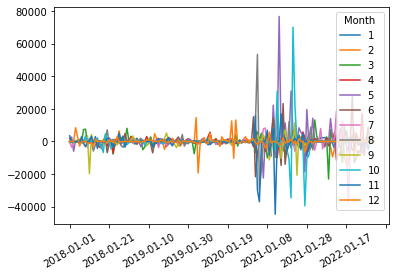

In [67]:
#seasonal_pnl.plot(x=seasonal_pnl.index.astype(str))
seasonal_pnl.set_index(seasonal_pnl.index.astype('str')).plot(rot=30)

In [70]:
#metrics.holdings, metrics.returns
# res = metrics.seasonal_pnl()
res_df = metrics.lead_lag()
print(res_df)

{'leadlag_sharpes':                               -20       -19       -18       -17       -16  \
fullsample              -0.101472  0.678731  0.053587 -0.384331 -0.329737   
1980-Jan-01:1989-Dec-31       NaN       NaN       NaN       NaN       NaN   
1990-Jan-01:1999-Dec-31       NaN       NaN       NaN       NaN       NaN   
2000-Jan-01:2009-Dec-31       NaN       NaN       NaN       NaN       NaN   
2010-Jan-01:2019-Dec-31 -1.265236  0.226739 -1.693957 -0.744997  0.093792   
2020-Jan-01:2029-Dec-31  0.193918  0.886653  0.589510 -0.366261 -0.475561   

                              -15       -14       -13       -12       -11  \
fullsample               0.125264 -0.893150 -1.358266 -1.498786 -1.257345   
1980-Jan-01:1989-Dec-31       NaN       NaN       NaN       NaN       NaN   
1990-Jan-01:1999-Dec-31       NaN       NaN       NaN       NaN       NaN   
2000-Jan-01:2009-Dec-31       NaN       NaN       NaN       NaN       NaN   
2010-Jan-01:2019-Dec-31  0.541375 -0.377697 -1.774671  

[Text(0.0, 0, '-20.0'),
 Text(5.0, 0, '-15.0'),
 Text(10.0, 0, '-10.0'),
 Text(15.0, 0, '-5.0'),
 Text(20.0, 0, '0.0'),
 Text(25.0, 0, '5.0'),
 Text(30.0, 0, '10.0'),
 Text(35.0, 0, '15.0'),
 Text(40.0, 0, '20.0'),
 Text(45.0, 0, '25.0'),
 Text(50.0, 0, '30.0'),
 Text(55.0, 0, '35.0'),
 Text(60.0, 0, '40.0'),
 Text(65.0, 0, '45.0'),
 Text(70.0, 0, '50.0'),
 Text(75.0, 0, '55.0'),
 Text(80.0, 0, '60.0')]

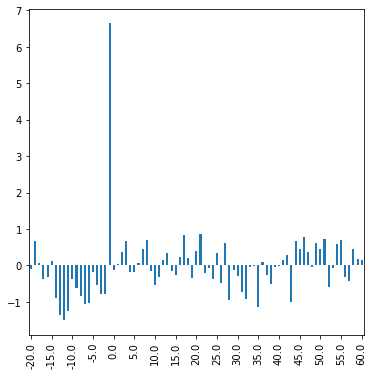

In [90]:
ts = res_df['leadlag_sharpes'].loc['fullsample']
ax = ts.plot(kind='bar',figsize=(6, 6))
new_ticks = np.linspace(-20, 60, 17)
ax.set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
ax.set_xticklabels(new_ticks)


                 1         2         5         10        20
sharpe     0.041510  0.371497 -0.178377 -0.545299  0.387321
sharpe_fh -0.097464  0.536867 -0.831639  1.740377  0.654060
sharpe_sh  0.072639  0.405681 -0.021329 -1.466374  0.335217


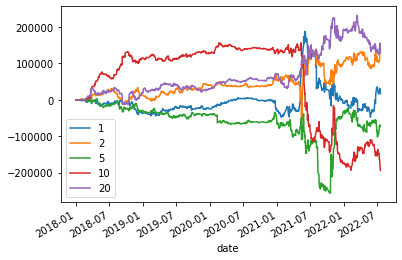

In [92]:
res = metrics.lagged_pnl(lags=[1,2,5,10,20])
res['cumpnl'].plot()
print(res['sharpe'])

                 1         2         5         10        20
sharpe     0.053036  0.225302  0.391806  0.432316  0.410546
sharpe_fh -0.394823 -0.291161 -0.175889 -0.103782 -0.037417
sharpe_sh  0.169686  0.388013  0.596382  0.641867  0.600427


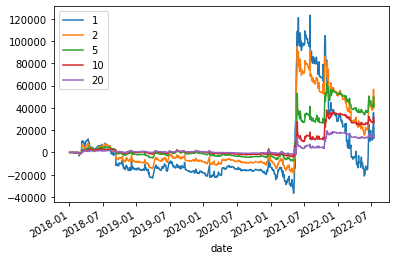

In [93]:
res = metrics.smoothed_pnl(smooth_hls=[1, 2, 5, 10, 20])
res['cumpnl'].plot()
print(res['sharpe'])


<AxesSubplot:xlabel='date'>

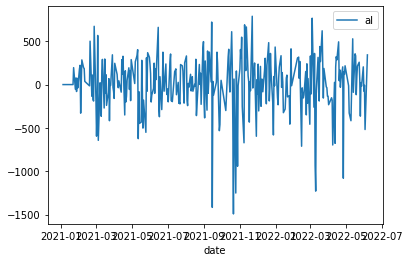

In [10]:
nb_df['holding'].to_frame('al').plot()

In [36]:
pd.to_datetime('2021-01-04').replace(day=1)

Timestamp('2021-01-01 00:00:00')

In [31]:
calendar_aggregation(nb_df, period = 'weekly', how = 'sum')

,open,high,low,close,volume,openInterest,month,price_chg,shift
date,,,,,,,,,
2021-01-08,1483.9,1543.1,1466.6,1524.9,281968,176433,15,18.9,-133.0
2021-01-15,1585.5,1616.8,1546.3,1575.8,550308,221988,15,-5.2,-133.0
2021-01-22,1554.8,1574.7,1529.9,1549.3,631411,232034,15,-7.1,-133.0
2021-01-29,1524.2,1550.3,1511.0,1528.8,107088,123896,20,2.3,-161.5
2021-02-05,1597.3,1628.2,1577.5,1614.2,187718,167511,20,24.0,-161.5
...,...,...,...,...,...,...,...,...,...
2022-05-06,1396.5,1413.7,1373.4,1395.9,73601,35847,14,24.8,0.0
2022-05-13,3406.1,3482.3,3323.5,3400.3,359275,112629,35,-2.3,0.0
2022-05-20,3514.8,3588.4,3446.9,3519.5,842207,160928,35,0.8,0.0


In [4]:
start_date = datetime.date(2014,1,1)
end_date = datetime.date(2022,6,17)

nb_df = dataseries.nearby('al', 1, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=1)
#nb1_df = dataseries.nearby('sc', 2, start_date = start_date, end_date = end_date, roll_rule='-20b',shift_mode=1)
#nb2_df = nearby('al', 2, start_date = start_date, end_date = end_date, roll_rule='-30b',shift_mode=2)
print(nb_df)

           contract     open     high      low    close  volume  openInterest  \
date                                                                            
2014-01-06   al1403  13625.0  13645.0  13550.0  13550.0    7706         49150   
2014-01-07   al1403  13555.0  13575.0  13545.0  13550.0    4834         48892   
2014-01-08   al1403  13550.0  13575.0  13480.0  13505.0    4134         48702   
2014-01-09   al1403  13505.0  13530.0  13440.0  13440.0    5276         48812   
2014-01-10   al1403  13440.0  13450.0  13395.0  13405.0    7156         47574   
...             ...      ...      ...      ...      ...     ...           ...   
2022-06-13   al2208  20450.0  20530.0  19935.0  20010.0  118856        104803   
2022-06-14   al2208  19845.0  20125.0  19840.0  20015.0   88304        109073   
2022-06-15   al2208  19950.0  20180.0  19730.0  19815.0  102628        113882   
2022-06-16   al2208  19850.0  20235.0  19850.0  19990.0  102326        119692   
2022-06-17   al2208  19700.0

In [11]:
print(load_fut_by_product('eg', 'DCE', datetime.date(2022,5,20) ,datetime.date(2022,5,20)))
#print(load_fut_by_product('sc', 'INE', datetime.date(2022,3,2) ,datetime.date(2022,3,2)))

    instID        date    open    high     low   close  volume  openInterest
0   eg2206  2022-05-20  4916.0  4964.0  4829.0  4829.0     811         12841
1   eg2207  2022-05-20  4958.0  5012.0  4876.0  4893.0   50266         76150
2   eg2208  2022-05-20  4997.0  5050.0  4914.0  4932.0   24505         45958
3   eg2209  2022-05-20  5039.0  5080.0  4950.0  4956.0  431737        286305
4   eg2210  2022-05-20  5055.0  5100.0  4975.0  4975.0   10219         28978
5   eg2211  2022-05-20  5056.0  5119.0  4993.0  4993.0    6682         12155
6   eg2212  2022-05-20  5148.0  5148.0  5148.0  5148.0       0             8
7   eg2301  2022-05-20  5116.0  5156.0  5034.0  5042.0     451          1724
8   eg2302  2022-05-20  5226.0  5226.0  5226.0  5226.0       0             7
9   eg2303  2022-05-20  5104.0  5104.0  5104.0  5104.0       0             1
10  eg2304  2022-05-20  5050.0  5050.0  5050.0  5050.0       0             1


In [7]:
#nb_df[nb1_df['instID'] == nb_df['instID']]
#nb_df.close.plot(color='r')

#nb1_df.close.plot(color='y')
print(nb1_df.close.diff().max(), nb1_df.price_chg.max())
#nb_df[['close']].plot()
#flag = nb1_df.close.diff()>1.0
#nb1_df[flag | flag.shift(-1)]
#nb1_df.loc[datetime.date(2018,9,8):datetime.date(2018,9,20):]

NameError: name 'nb1_df' is not defined

In [2]:
start_date = datetime.date(2011,1,1)
end_date = datetime.date(2022, 1, 28)
prodcode = 'ZC'
roll_rule = '-30b'
shift_mode = 1
n = 1

adj_field = 'close'
calc_fields = ['open', 'close', 'high', 'low']
contract_filter = [1, 5, 9]

exch = misc.prod2exch(prodcode)
xdf = load_fut_by_product(prodcode, exch, start_date ,end_date)
xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
xdf = xdf.sort_values(['instID', 'date'])

if shift_mode == 2:
    xdf['price_chg'] = np.log(xdf[adj_field]).diff()
else:
    xdf['price_chg'] = xdf[adj_field].diff()        
xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
    xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
    xdf = xdf[xdf.date <= xdf['roll_date']]
else:
    xdf['roll_date'] = xdf['expiry']
if contract_filter:
    xdf = xdf[xdf.month.isin(contract_filter)]
df = pd.pivot_table(xdf, index = 'date', columns = 'expiry', values = 'instID', aggfunc = 'first')
df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
df1 = df1.reset_index()

col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
#if len(col_df[col_df['instID'].isna()])> 0:
#    raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s' % (prodcode, str(n), roll_rule))
col_df = col_df.fillna(method = 'ffill')
out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')

if shift_mode > 0:
    cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
    if shift_mode == 2:
        adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
        out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
    else:
        adj_price = out_df[adj_field].iloc[-1] - cum_adj
        out_df['shift'] = adj_price - out_df[adj_field]    

    for cfield in calc_fields:
        if shift_mode == 2:
            out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
        else:
            out_df[cfield] = out_df[cfield] + out_df['shift']
else:
    out_df['shift'] = 0
out_df = out_df.set_index('date')

In [6]:
load_fut_by_product('TA', 'CZCE', start_date ,end_date)

,instID,date,open,high,low,close,volume,openInterest
0,TA1101,2011-01-04,9986.0,10194.0,9948.0,10172.0,1826,26168
1,TA1102,2011-01-04,10152.0,10152.0,10152.0,10152.0,6,230
2,TA1103,2011-01-04,10340.0,10412.0,10320.0,10398.0,28,274
3,TA1104,2011-01-04,10498.0,10522.0,10344.0,10522.0,6,212
4,TA1105,2011-01-04,10430.0,10620.0,10372.0,10592.0,446228,225166
...,...,...,...,...,...,...,...,...
23472,TA209,2022-01-28,5516.0,5570.0,5446.0,5480.0,51837,142881
23473,TA210,2022-01-28,5572.0,5606.0,5506.0,5506.0,46,4695
23474,TA211,2022-01-28,5586.0,5616.0,5514.0,5538.0,36,2882
23475,TA212,2022-01-28,5602.0,5620.0,5590.0,5592.0,7,2519


In [144]:
#out_df[out_df.instID.isna()]

#out_df.loc[datetime.date(2017,11,20):datetime.date(2017,12,10),:]
#out_df.close.plot()
print(out_df.close.diff().max(),out_df.price_chg.max())

1.2449999999999903 1.2449999999999903


In [5]:
price_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
price_close = out_df['close'].iloc[-1] - price_adj
price_shift = price_close - out_df['close']
print(price_close, price_shift)

0      12365.0
1      12360.0
2      12380.0
3      12380.0
4      12435.0
        ...   
500    21025.0
501    21055.0
502    21525.0
503    21540.0
504    21950.0
Name: price_chg, Length: 505, dtype: float64 0     -1725.0
1     -1725.0
2     -1725.0
3     -1645.0
4     -1645.0
        ...  
500       0.0
501       0.0
502       0.0
503       0.0
504       0.0
Length: 505, dtype: float64


In [55]:
xdf = xdf.sort_values(['instID', 'date'])
xdf['chg'] = xdf['close'].diff()
flag = xdf['instID']!=xdf['instID'].shift(1)
xdf.loc[flag, 'chg'] = 0
print(xdf)

      instID        date     open     high      low    close  volume  \
0     al2001  2020-01-02  14355.0  14425.0  14355.0  14410.0    5391   
12    al2001  2020-01-03  14390.0  14425.0  14375.0  14410.0    8795   
24    al2001  2020-01-06  14425.0  14460.0  14390.0  14415.0    6025   
36    al2001  2020-01-07  14410.0  14420.0  14300.0  14300.0   10600   
48    al2001  2020-01-08  14260.0  14405.0  14260.0  14400.0    5570   
...      ...         ...      ...      ...      ...      ...     ...   
5967  al2301  2022-01-24  21140.0  21180.0  20840.0  20845.0      16   
5979  al2301  2022-01-25  20935.0  20940.0  20845.0  20850.0      31   
5991  al2301  2022-01-26  21220.0  21415.0  21145.0  21395.0      62   
6003  al2301  2022-01-27  21310.0  21395.0  21295.0  21395.0       3   
6015  al2301  2022-01-28  21365.0  21600.0  21340.0  21600.0      29   

      openInterest      expiry   roll_date    chg  
0            45835  2020-01-15  2019-12-04    0.0  
12           41670  2020-01-15 

In [4]:
adf = df.iloc[:, df.columns.get_level_values(0)=='close']
nb_df = nearby(adf, roll = 30)
print(nb_df[0])

close                                                         \
expiry     2021-01-15 2021-02-15 2021-03-15 2021-04-15 2021-05-17 2021-06-15   
date                                                                           
2021-01-04    15615.0    15430.0    15330.0    15290.0    15250.0    15205.0   
2021-01-05    15575.0    15370.0    15310.0    15290.0    15270.0    15220.0   
2021-01-06    15585.0    15400.0    15380.0    15390.0    15380.0    15335.0   
2021-01-07    15530.0    15320.0    15315.0    15325.0    15305.0    15280.0   
2021-01-08    15530.0    15340.0    15290.0    15300.0    15290.0    15215.0   
...               ...        ...        ...        ...        ...        ...   
2022-01-24        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-25        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-26        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-27        NaN        NaN        NaN        NaN        NaN        NaN   
2022-01-28        NaN        NaN        NaN        NaN        NaN        NaN   

                                                        ...             \
expiry     2021-07-15 2021-08-16 2021-09-15 2021-10-15  ... 2022-04-15   
date                                                    ...              
2021-01-04    15190.0    15165.0    15160.0    15095.0  ...        NaN   
2021-01-05    15190.0    15110.0    15105.0    15080.0  ...        NaN   
2021-01-06    15305.0    15275.0    15250.0    15230.0  ...        NaN   
2021-01-07    15245.0    15200.0    15260.0    15180.0  ...        NaN   
2021-01-08    15170.0    15160.0    15145.0    15075.0  ...        NaN   
...               ...        ...        ...        ...  ...        ...   
2022-01-24        NaN        NaN        NaN        NaN  ...    21025.0   
2022-01-25        NaN        NaN        NaN        NaN  ...    21055.0   
2022-01-26        NaN        NaN        NaN        NaN  ...    21525.0   
2022-01-27        NaN        NaN        NaN        NaN  ...    21540.0   
2022-01-28        NaN        NaN        NaN        NaN  ...    21895.0   

                                                                              \
expiry     2022-05-16 2022-06-15 2022-07-15 2022-08-15 2022-09-15 2022-10-17   
date                                                                           
2021-01-04        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-05        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-07        NaN        NaN        NaN        NaN        NaN        NaN   
2021-01-08        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2022-01-24    21000.0    20980.0    20930.0    20940.0    20990.0    20885.0   
2022-01-25    21045.0    21025.0    21010.0    21010.0    21015.0    21135.0   
2022-01-26    21495.0    21475.0    21445.0    21485.0    21425.0    21460.0   
2022-01-27    21525.0    21505.0    21465.0    21445.0    21435.0    21410.0   
2022-01-28    21820.0    21780.0    21735.0    21685.0    21670.0    21660.0   

                                             
expiry     2022-11-15 2022-12-15 2023-01-16  
date                                         
2021-01-04        NaN        NaN        NaN  
2021-01-05        NaN        NaN        NaN  
2021-01-06        NaN        NaN        NaN  
2021-01-07        NaN        NaN        NaN  
2021-01-08        NaN        NaN        NaN  
...               ...        ...        ...  
2022-01-24    20830.0    20770.0    20845.0  
2022-01-25    20990.0    20910.0    20850.0  
2022-01-26    21440.0    21430.0    21395.0  
2022-01-27    21400.0    21460.0    21395.0  
2022-01-28    21710.0    21620.0    21600.0  

[262 rows x 25 columns]

In [70]:
import pypfopt

In [6]:
def nearby(prodcode, n = 1, start_date = None, end_date = None, 
           roll_rule = '-20b', shift_mode = 0, 
           adj_field = 'close', calc_fields = ['open', 'close', 'high', 'low'], 
           contract_filter = None, fill_cont = False,
          ):
    exch = misc.prod2exch(prodcode)
    xdf = load_fut_by_product(prodcode, exch, start_date ,end_date)
    xdf['expiry'] = xdf['instID'].apply(lambda x: misc.contract_expiry(x, hols = misc.CHN_Holidays))
    xdf['month'] = xdf['instID'].apply(lambda x: misc.inst2contmth(x)%100)
    xdf = xdf.sort_values(['instID', 'date'])

    if shift_mode == 2:
        xdf['price_chg'] = np.log(xdf[adj_field]).diff()
    else:
        xdf['price_chg'] = xdf[adj_field].diff()        
    xdf.loc[xdf['instID']!=xdf['instID'].shift(1), 'price_chg'] = 0
    if (roll_rule[0] == '-') and (roll_rule[-1] in ['b', 'd']):
        xdf['roll_date'] = xdf['expiry'].apply(lambda x: misc.day_shift(x, roll_rule, hols = misc.CHN_Holidays))
        xdf = xdf[xdf.date <= xdf['roll_date']]
    else:
        xdf['roll_date'] = xdf['expiry']
    if contract_filter:
        xdf = xdf[xdf.month.isin(contract_filter)]
    df = pd.pivot_table(xdf, index = 'date', columns = 'expiry', values = 'instID', aggfunc = 'first')
    df1 = df.apply(lambda x: pd.Series(x.dropna().values), axis=1)
    df1 = df1.reset_index()
    col_df = df1[['date', n-1]].rename(columns = {n-1: 'instID'})
    if len(col_df[col_df['instID'].isna()])> 0:
        if fill_cont:
            col_df = col_df.fillna(method = 'ffill')
        else:
            raise ValueError('There are nan values for product=%s, nearby=%s, roll=%s' % (prodcode, str(n), roll_rule))
    out_df = pd.merge(col_df, xdf,left_on = ['date', 'instID'], right_on=['date', 'instID'], how = 'left')
    if shift_mode > 0:
        cum_adj = out_df.loc[::-1, 'price_chg'].cumsum().shift(1).fillna(0)[::-1]
        if shift_mode == 2:
            adj_price = out_df[adj_field].iloc[-1]/np.exp(cum_adj)
            out_df['shift'] = np.log(adj_price) - np.log(out_df[adj_field])
        else:
            adj_price = out_df[adj_field].iloc[-1] - cum_adj
            out_df['shift'] = adj_price - out_df[adj_field]    

        for cfield in calc_fields:
            if shift_mode == 2:
                out_df[cfield] = out_df[cfield] * np.exp(out_df['shift'])
            else:
                out_df[cfield] = out_df[cfield] + out_df['shift']
    else:
        out_df['shift'] = 0
    out_df = out_df.set_index('date')
    return out_df

,instID,date,open,high,low,close,volume,openInterest
0,ME1203,2011-10-28,3199.0,3220.0,3130.0,3139.0,40508,3342
1,ME1204,2011-10-28,3150.0,3209.0,3143.0,3148.0,102,44
2,ME1205,2011-10-28,3192.0,3233.0,3172.0,3182.0,3024,424
3,ME1206,2011-10-28,3258.0,3258.0,3195.0,3195.0,4,2
4,ME1209,2011-10-28,3195.0,3263.0,3189.0,3198.0,108,62
...,...,...,...,...,...,...,...,...
14173,MA209,2022-01-28,2805.0,2895.0,2780.0,2794.0,15715,56821
14174,MA210,2022-01-28,2860.0,2902.0,2801.0,2801.0,1521,7209
14175,MA211,2022-01-28,2863.0,2901.0,2793.0,2814.0,17,14448
14176,MA212,2022-01-28,2889.0,2930.0,2832.0,2832.0,15,4949


In [65]:
import json

with open("C:/dev/wtdev/common/hots.json", 'r') as infile:
    config = json.load(infile)
print(config)

{'CFFEX': {'IC': [{'date': 20190102, 'from': '', 'newclose': 4096.8, 'oldclose': 0.0, 'to': 'IC1901'}, {'date': 20190117, 'from': 'IC1901', 'newclose': 4325.2, 'oldclose': 4341.0, 'to': 'IC1902'}, {'date': 20190214, 'from': 'IC1902', 'newclose': 4509.8, 'oldclose': 4512.0, 'to': 'IC1903'}, {'date': 20190314, 'from': 'IC1903', 'newclose': 5390.4, 'oldclose': 5403.6, 'to': 'IC1904'}, {'date': 20190418, 'from': 'IC1904', 'newclose': 5742.8, 'oldclose': 5772.4, 'to': 'IC1905'}, {'date': 20190516, 'from': 'IC1905', 'newclose': 4959.4, 'oldclose': 5046.2, 'to': 'IC1906'}, {'date': 20190620, 'from': 'IC1906', 'newclose': 4785.0, 'oldclose': 4855.0, 'to': 'IC1907'}, {'date': 20190718, 'from': 'IC1907', 'newclose': 4853.0, 'oldclose': 4911.4, 'to': 'IC1908'}, {'date': 20190815, 'from': 'IC1908', 'newclose': 4617.2, 'oldclose': 4672.0, 'to': 'IC1909'}, {'date': 20190919, 'from': 'IC1909', 'newclose': 5099.0, 'oldclose': 5130.8, 'to': 'IC1910'}, {'date': 20191017, 'from': 'IC1910', 'newclose': 49

In [68]:

pd.DataFrame.from_records(config['CFFEX']['IF'])

,date,from,newclose,oldclose,to
0,20190102,,2962.2,0.0,IF1901
1,20190117,IF1901,3131.0,3129.4,IF1902
2,20190214,IF1902,3405.2,3397.4,IF1903
3,20190314,IF1903,3725.0,3720.8,IF1904
4,20190418,IF1904,4086.2,4080.6,IF1905
5,20190516,IF1905,3692.6,3715.2,IF1906
6,20190620,IF1906,3691.8,3718.4,IF1907
7,20190718,IF1907,3782.8,3794.6,IF1908
8,20190815,IF1908,3653.6,3673.4,IF1909
9,20190919,IF1909,3901.2,3904.2,IF1910
